In [1]:
import os
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

Credit: A machine learning approach to predicting protein-ligand binding affinity with applications to molecular docking. 
P.J. Ballester & J.B.O. Mitchell, Bioinformatics, 26, 1169-1175 (2010)                                                                                                       
Rewrite of RF-Score_desc.c & RF-Score_pred.r in python, by OZhang 03.2023

Reads a list of PDBbind protein-ligand complexes and calculate their RF-Score descriptors                 

In [ ]:
#    1 : ["H" , "HA" , "HA1" , "HA2" , "HB" , "HB1" , "HB2" , "HB3" , "HD1" , "HD2" , 
#         "1HD2", "1HD3", "2HD2", "2HD3", "1HE2", "1HE3", "2HE2", "2HE3",
#         "HE" , "HE1" , "HE2" , "HE3" , "HG" , "HG1" , "HG2" , "1HG2", "1HG3", "2HG2", "2HG3", 
#         "HH", "HH1", "HH2", "1HH1", "2HH1", "1HH2", "2HH2", "HZ1", "HZ2", "HZ3", 
#         "HN1", "HN", "HN2", "HN3"],

In [376]:
NATOMAX = 3500   # maximum number of heavy atoms in the bindsite
NLIGATMAX = 250 # maximum number of heavy atoms in the ligand
NELEMTS = 54   # maximum number of chemical elements considered
DCUTOFF = 12   # distance cutoff for protein atoms near ligand
VERBOSE = 0  # show information about run

atomic_number_to_name = {
    6 : ["C" , "CA" , "CB" , "CD" , "CD1" , "CD2" , "CE" , "CE1" , 
                    "CE2", "CE3", "CG", "CG1", "CG2", "CH2", "CZ", "CZ2", "CZ3"],
    8 : ["O" , "OD1" , "OD2" , "OE1" , "OE1A" , "OE1B" , "OE2" , "OG" , "OG1", "OH", "OXT"],
    7 : ["N" , "NE" , "NE1" , "NE2" , "NE2A" , "NE2B" , "ND1" , "ND2" , "NH1" , "NH2" , "NZ"],
    9 : ["F"],
    15 : ["P"],
    16 : ["S" , "SD" , "SG"],
    17 : ["Cl"],
    35 : ["Br"],
    53 : ["I"],
}

name_to_atomic_number = { }
for k, v in atomic_number_to_name.items():
    for i in v:
        name_to_atomic_number[i] = k

In [377]:
class PdbLine:
    def __init__(self, input):
        self.lineid = input[0].strip()
        self.atomid = int(input[1].strip())
        self.atomtype = input[2].strip()
        self.resname = input[3].strip()
        self.chainid = input[4].strip()
        self.resid = int(input[5].strip())
        self.r = [float(i.strip()) for i in input[6:9]]
        self.prob = float(input[9].strip())
        self.dum = float(input[10].strip())
        self.atomname = input[11].strip()
    
    def set_atomnumber(self, a):
        self.atomnumber = a

class Ligand:
    def __init__(self):
        self.natoms = 0
        self.atomid = [0] * NATOMAX
        self.atomtype = [" " * 5] * NATOMAX
        self.protname = ""
        self.chainid = ""
        self.resid = 0
        self.r = [[0.0] * 3] * NATOMAX
        self.atomname = [" " * 4] * NATOMAX
        self.atomnumber = [0] * NATOMAX
        self.bindaff = 0.0
      

In [378]:
def read_pdb_file(filename):
    pdb_lines = []
    with open(filename, "r") as f:
        for line in f.readlines():
            if line.startswith("ATOM"):
                indices = [0, 6, 12, 17, 20, 22, 26, 30, 38, 46, 54, 60, 66, 78]
                items = [line.strip()[i:j] for i, j in zip(indices, indices[1:]+[None])]
                items.pop(6)
                pdb_line = PdbLine(items)
                atomnumber = name_to_atomic_number.get(pdb_line.atomtype)
                if atomnumber is None:
                    continue
                pdb_line.set_atomnumber(atomnumber)
                pdb_lines.append(pdb_line)
    return pdb_lines

def read_ligand_sdf(filename, bind_dict=None):
    ligand = Ligand()
    with open(filename, "r") as f:
        lines = f.readlines()
        ligand.natoms = int(lines[3][:3].strip())
        if ligand.natoms > NLIGATMAX:
            # then correct reading error
            ligand.natoms = int(line[3][:2].strip())
        ligand.protname = lines[0].split("_")[0].strip()
        for i in range(ligand.natoms):
            line = lines[i+4].split()
            atomnumber = name_to_atomic_number.get(line[3])
            if atomnumber is None:
                continue
            ligand.atomid[i] = i+1
            ligand.atomtype[i] = line[3]
            ligand.r[i][0] = float(line[0])
            ligand.r[i][1] = float(line[1])
            ligand.r[i][2] = float(line[2])
            ligand.atomnumber[i] = atomnumber
        if bind_dict:
            ligand.bindaff = bind_dict[ligand.protname]
        return ligand      

In [379]:
def read_bindaff(filename):
    data = np.loadtxt(filename, dtype={'names': ('pdbid', 'affinity'),
                     'formats': ('U4', 'f4')})
    return {data[i][0] : [data[i][1]] for i in range(data.shape[0])}

In [382]:
def RF_descriptor(dat_file, struct_dir, output=None):
    bindaff_dict = read_bindaff(dat_file)
    for prot_name in bindaff_dict:
        pname_lc = prot_name.lower()
        ligand_file = os.path.join(struct_dir, pname_lc, pname_lc +"_ligand.sdf")
        pocket_file = os.path.join(struct_dir, pname_lc, pname_lc +"_pocket.pdb")
        if not os.path.exists(ligand_file):
            if VERBOSE: print(prot_name, "does not exists in dir", struct_dir)
            continue
        if not os.path.exists(pocket_file):
            if VERBOSE: print(prot_name, "pocket does not exists in dir", struct_dir, "; read protein file instead")
            pocket_file = os.path.join(struct_dir, pname_lc, pname_lc +"_protein.pdb")
            if not os.path.exists(pocket_file):
                if VERBOSE: print(prot_name, "does not exists in dir", struct_dir)
                continue

        ligand = read_ligand_sdf(ligand_file)
        pocket = read_pdb_file(pocket_file)
        features = np.zeros((NELEMTS, NELEMTS))

        # Calculate distances between current ligand and its binding site
        break_loop = False
        visited = set()
        for k in range(ligand.natoms):
            for l in range(len(pocket)):
                ddum = np.linalg.norm(np.array(ligand.r[k]) - np.array(pocket[l].r))
                if ddum < DCUTOFF:
                    features[pocket[l].atomnumber, ligand.atomnumber[k]] += 1
                    visited.add(l)
                    if len(visited) >= NATOMAX:
                        break_loop = True
                        if VERBOSE:
                            print("exceed maximum binding site heavy atom limit")
                        break
            if break_loop:
                break
        col_mask = list(atomic_number_to_name.keys())
        bindaff_dict[prot_name].append(features[col_mask][:, col_mask])

    # reorder output
    new_dict = {"pdbid": list(bindaff_dict.keys()),
                "affinity": np.array([bindaff_dict[key][0] for key in bindaff_dict]),
                "feature": [bindaff_dict[key][1] if len(bindaff_dict[key]) > 1 else None
                            for key in bindaff_dict]}
    # save output
    if output is not None: 
        np.savez(output, **new_dict)
    return new_dict

In [383]:
# generate complexes descriptors
testdata = RF_descriptor("RF-Score_scripts/PDBbind_core07.txt", "pdbbind_v2007")
traindata = RF_descriptor("RF-Score_scripts/PDBbind_refined07-core07.txt", "pdbbind_v2007")

In [394]:
np.savez("RF-Score_scripts/PDBbind_refined07_desc.npz", **traindata)

RandomForest training

In [ ]:
# Reading Training (TRN) and Test (TST) Datasets; generated with RFscore_descriptor.py
#testdata = np.load("PDBbind_refined07_desc.npz")
#traindata = np.load("PDBbind_core07_desc.npz")

In [384]:
ntrndata = len(traindata["pdbid"])  # number of pdb complexes for training
ntstdata = len(testdata["pdbid"])  # number of pdb complexes for testing
seed = 1

itrain = np.arange(ntrndata)
nsample = ntrndata
np.random.seed(seed)
np.random.shuffle(itrain)  # shuffle selected complexes
train_y = np.array(traindata["affinity"])[itrain]
train_X = np.array(traindata["feature"])[itrain]
train_pdbnames = np.array(traindata["pdbid"])[itrain]
test_y = np.array(testdata["affinity"])
test_X = np.array(testdata["feature"])

test_pdbnames = testdata["pdbid"]

In [385]:
# Data pre-processing; remove all zeros entries
train_X_f = np.reshape(train_X, (ntrndata, -1))
test_X_f = np.reshape(test_X, (ntstdata, -1))
all_X = np.vstack((train_X_f, test_X_f))
col_mask = np.sum(all_X, axis = 0) > 0
col_mask.sum()

36

In [386]:
#col_mask = np.r_[1:3, 6, 10:12, 15, 19:21, 24, 28:30, 33, 37:39, 42, 
#                 46:48, 51, 55:57, 60, 64:66, 69, 73:75, 78]
train_Xs = train_X_f[:, col_mask]
test_Xs = test_X_f[:, col_mask]

In [387]:
# Selecting RF with best internal validation (RF-SCORE)
rmse_OOB_best = 1e8  # dummy high value
for mtry in range(2, 20):
    RF_mtry = RandomForestRegressor(n_estimators=500, max_features=mtry, oob_score=True)
    RF_mtry.fit(train_Xs, train_y)
    rmse_OOB = np.sqrt(np.mean((RF_mtry.oob_prediction_ - train_y) ** 2))
    if rmse_OOB < rmse_OOB_best:
        mbest = mtry
        rmse_OOB_best = rmse_OOB
        print("mbest = ", mbest, "rmse_OOB = ", round(rmse_OOB, 3))
    #print("mtry = ", mtry)

mbest =  2 rmse_OOB =  1.622
mbest =  3 rmse_OOB =  1.618


In [396]:
RF_Score = RandomForestRegressor(n_estimators=500, max_features=mbest)
RF_Score.fit(train_Xs, train_y)

# train performance
train_pred = RF_Score.predict(train_Xs)
train_rmse = np.round(((train_y - train_pred)**2).mean() ** 0.5, 3)
train_sdev = np.round((train_y - train_pred).std(), 3)
fitpoints = pd.concat([pd.DataFrame(train_y), pd.DataFrame(train_pred)], axis=1).dropna()
fitcorr = np.round(fitpoints.corr(method='pearson').iloc[0, 1], 3)
sprcorr = np.round(fitpoints.corr(method='spearman').iloc[0, 1], 3)

In [397]:
fitcorr, sprcorr

(0.975, 0.975)

In [390]:
# test performance
test_pred = RF_Score.predict(test_Xs)
test_rmse = np.round(((test_y - test_pred)**2).mean() ** 0.5, 3)
test_sdev = np.round((test_y - test_pred).std(), 3)
fitpoints = pd.concat([pd.DataFrame(test_y), pd.DataFrame(test_pred)], axis=1).dropna()
fitcorr = np.round(fitpoints.corr(method='pearson').iloc[0, 1], 3)
sprcorr = np.round(fitpoints.corr(method='spearman').iloc[0, 1], 3)
fitcorr, sprcorr

(0.679, 0.677)

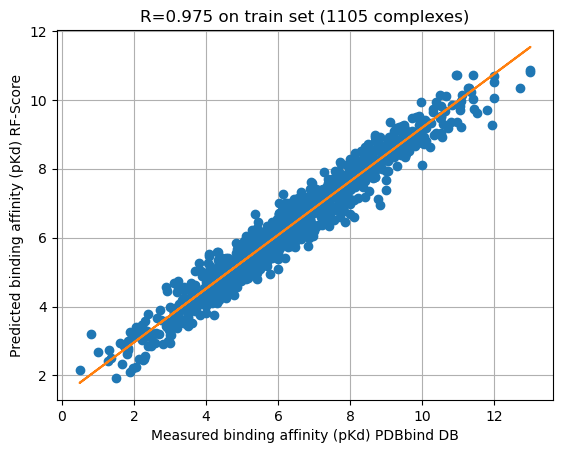

In [398]:
plot_prediction(fitpoints, "train")

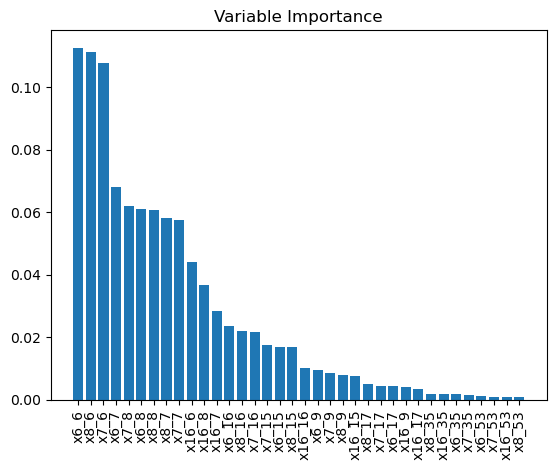

In [392]:
colname = [[f"x{i}_{j}" for j in list(atomic_number_to_name.keys())] for i in list(atomic_number_to_name.keys())]
colname = np.reshape(colname, -1)
plot_importance(RF_Score, train_Xs, colname[col_mask])

In [373]:
import matplotlib.pyplot as plt

def plot_prediction(fitpoints, mode = "train"):
    plt.plot(fitpoints.iloc[:,0], fitpoints.iloc[:,1], 'o')
    prline = np.polyfit(fitpoints.iloc[:,0], fitpoints.iloc[:,1], 1)
    plt.plot(fitpoints.iloc[:,0], np.polyval(prline, fitpoints.iloc[:,0]), '-')
    plt.title("R=" + str(fitcorr) + f" on {mode} set (" + str(fitpoints.shape[0]) + " complexes)")
    plt.xlabel("Measured binding affinity (pKd) PDBbind DB")
    plt.ylabel("Predicted binding affinity (pKd) RF-Score")
    plt.grid()
    plt.show()

# Variable importance by RF-SCORE
def plot_importance(RF_Score, X, colnames):
    importances = RF_Score.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure()
    plt.title("Variable Importance")
    plt.bar(range(X.shape[1]), importances[indices])
    plt.xticks(range(X.shape[1]), colnames[indices], rotation=90)
    plt.show()